# Sprint 3: Pothole Segmentation and Metrology

**Project:** Road Defect Detection Pipeline (PROSIT 1)  
**Team:** Naa Lamle Boye, Thomas Kojo Quarshie, Chelsea Owusu, Elijah Boateng  
**Date:** February 2026

## Purpose

This notebook detects potholes in the top-down road image and measures their area in
**cm²** using the known scale (10 px = 1 cm). On Ghanaian roads, potholes filled with
sand/dirt appear as **sandy/orange patches** distinct from the gray asphalt.

**Detection approach:** HSV color segmentation to find warm-colored (sandy) patches that
differ from the neutral gray road surface.

**Input:** `topdown_full.png` from Sprint 1 (original top-down, preserves color contrast)  
**Output:** `pothole_detection_report.csv` with Frame_ID, Pothole_ID, Area_cm2, Center

## Step 1: Import Libraries

In [1]:
import numpy as np
import cv2
import csv
import os
%matplotlib inline
import matplotlib.pyplot as plt

print(f"OpenCV: {cv2.__version__}")

OpenCV: 4.13.0


## Step 2: Load Top-Down View

We use the original (unrestored) top-down view because it preserves the natural color
contrast between the sandy pothole and the gray road. The Retinex restoration in Sprint 2
normalizes illumination but can wash out the color differences we need for detection.

Loaded: 2090x2120 px
Scale: 10.0 px/cm => image covers 209 x 212 cm


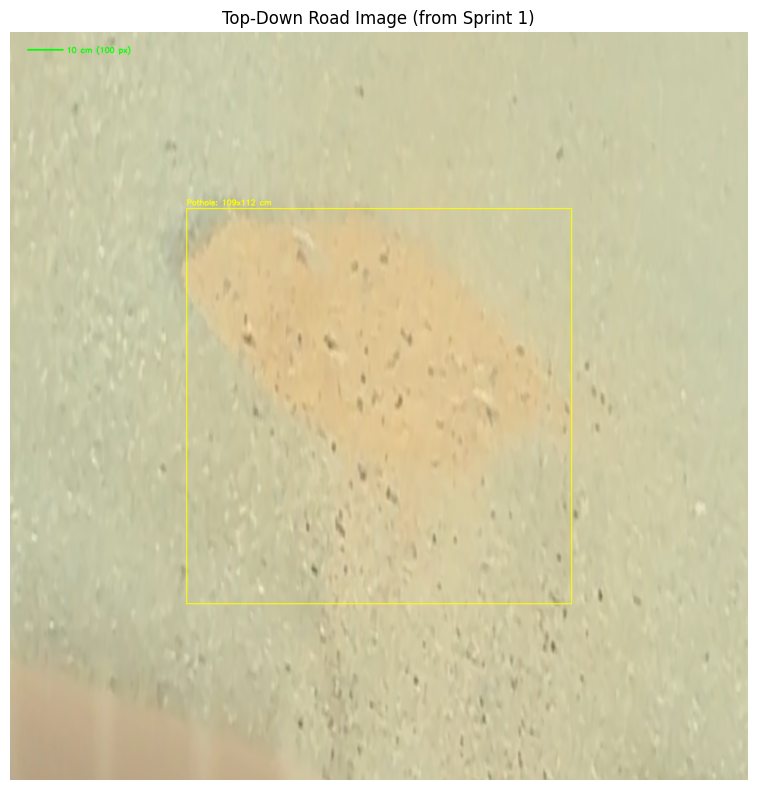

In [2]:
# Use the original top-down view (better color contrast for detection)
topdown = cv2.imread('topdown_full.png')
if topdown is None:
    raise FileNotFoundError("topdown_full.png not found. Run Sprint 1 first.")

SCALE = 10.0  # 10 px = 1 cm
print(f"Loaded: {topdown.shape[1]}x{topdown.shape[0]} px")
print(f"Scale: {SCALE} px/cm => image covers {topdown.shape[1]/SCALE:.0f} x {topdown.shape[0]/SCALE:.0f} cm")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
ax.set_title("Top-Down Road Image (from Sprint 1)")
ax.axis('off')
plt.tight_layout()
plt.show()

## Step 3: Pothole Detection via Color Segmentation

Potholes on Ghanaian roads are often filled with sand/dirt, making them appear
**warm/orange** against the **cool/gray** asphalt. We detect these using:
1. Convert to HSV color space
2. Threshold on **Hue** (8-22 for warm orange tones) and **Saturation** (>45 for distinctly colored patches)
3. Morphological cleanup to remove noise
4. Contour analysis for area measurement

In [3]:
def detect_road_defects(image, scale=10.0, min_area_cm2=50, max_area_cm2=50000):
    """
    Detect sandy/damaged patches on road using HSV color segmentation.
    
    Potholes filled with sand appear warm/orange against gray road.
    We detect regions with warm hue and elevated saturation.
    
    Args:
        image: Top-down road image (BGR)
        scale: pixels per cm (default 10)
        min_area_cm2: minimum defect area to report
        max_area_cm2: maximum defect area to report
    
    Returns:
        list of dicts with pothole measurements
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Detect warm-colored (sandy/orange) patches
    # Hue 8-22: orange to warm brown
    # Saturation > 45: distinctly colored (not neutral gray)
    # Value 120-240: reasonably bright (not in shadow)
    mask = cv2.inRange(hsv, np.array([8, 45, 120]), np.array([22, 200, 240]))
    
    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and measure
    potholes = []
    for cnt in sorted(contours, key=cv2.contourArea, reverse=True):
        area_px = cv2.contourArea(cnt)
        area_cm2 = area_px / scale**2
        
        if min_area_cm2 <= area_cm2 <= max_area_cm2:
            M = cv2.moments(cnt)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = 0, 0
            
            x, y, w, h = cv2.boundingRect(cnt)
            perimeter = cv2.arcLength(cnt, True) / scale
            eq_diam = 2 * np.sqrt(area_cm2 / np.pi)
            aspect = float(w) / h if h > 0 else 1.0
            extent = area_px / (w * h) if w * h > 0 else 0
            
            potholes.append({
                'id': len(potholes) + 1,
                'area_cm2': area_cm2,
                'center_px': (cx, cy),
                'center_cm': (cx / scale, cy / scale),
                'contour': cnt,
                'bbox': (x, y, w, h),
                'perimeter_cm': perimeter,
                'eq_diameter_cm': eq_diam,
                'aspect_ratio': aspect,
                'extent': extent
            })
    
    return potholes, mask

potholes, det_mask = detect_road_defects(topdown, scale=SCALE, min_area_cm2=50)
print(f"Detected {len(potholes)} road defect(s)\n")
for p in potholes:
    print(f"  Pothole #{p['id']}:")
    print(f"    Area: {p['area_cm2']:.1f} cm2")
    print(f"    Center: ({p['center_cm'][0]:.1f}, {p['center_cm'][1]:.1f}) cm")
    print(f"    Perimeter: {p['perimeter_cm']:.1f} cm")
    print(f"    Equivalent Diameter: {p['eq_diameter_cm']:.1f} cm")
    print(f"    Aspect Ratio: {p['aspect_ratio']:.2f}")
    print(f"    Extent: {p['extent']:.2f}")

Detected 2 road defect(s)

  Pothole #1:
    Area: 6001.0 cm2
    Center: (103.7, 94.7) cm
    Perimeter: 616.2 cm
    Equivalent Diameter: 87.4 cm
    Aspect Ratio: 0.96
    Extent: 0.48
  Pothole #2:
    Area: 1698.1 cm2
    Center: (31.6, 199.9) cm
    Perimeter: 255.5 cm
    Equivalent Diameter: 46.5 cm
    Aspect Ratio: 2.63
    Extent: 0.54


## Step 4: Visualize Detection Mask and Results

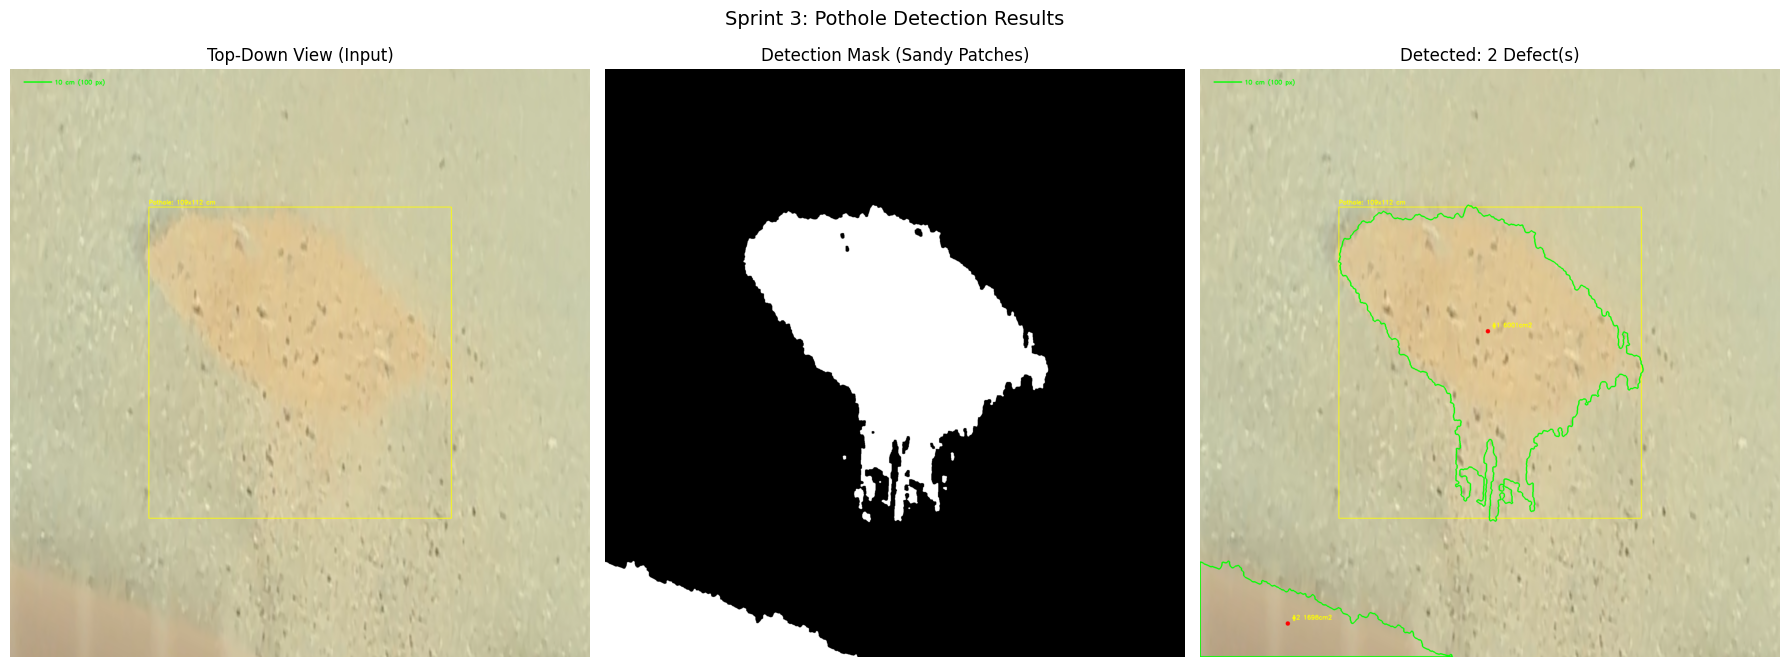

Saved: segmentation_comparison.png, test_segmentation_output.png


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
axes[0].set_title("Top-Down View (Input)")
axes[0].axis('off')

axes[1].imshow(det_mask, cmap='gray')
axes[1].set_title("Detection Mask (Sandy Patches)")
axes[1].axis('off')

# Annotated image
annotated = topdown.copy()
for p in potholes:
    cv2.drawContours(annotated, [p['contour']], -1, (0, 255, 0), 3)
    cv2.circle(annotated, p['center_px'], 8, (0, 0, 255), -1)
    cx, cy = p['center_px']
    cv2.putText(annotated, f"#{p['id']} {p['area_cm2']:.0f}cm2",
        (cx+15, cy-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

axes[2].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"Detected: {len(potholes)} Defect(s)")
axes[2].axis('off')

plt.suptitle("Sprint 3: Pothole Detection Results", fontsize=14)
plt.tight_layout()
plt.savefig('segmentation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

cv2.imwrite('test_segmentation_output.png', annotated)
print("Saved: segmentation_comparison.png, test_segmentation_output.png")

## Step 5: Generate CSV Report

The final deliverable: a CSV file with pothole measurements.

In [5]:
csv_path = 'pothole_detection_report.csv'
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Frame_ID', 'Pothole_ID', 'Area_cm2', 'Center_X_cm', 'Center_Y_cm',
                     'Perimeter_cm', 'Equivalent_Diameter_cm', 'Aspect_Ratio'])
    for p in potholes:
        writer.writerow([
            'pothole_1',
            p['id'],
            f"{p['area_cm2']:.2f}",
            f"{p['center_cm'][0]:.2f}",
            f"{p['center_cm'][1]:.2f}",
            f"{p['perimeter_cm']:.2f}",
            f"{p['eq_diameter_cm']:.2f}",
            f"{p['aspect_ratio']:.2f}"
        ])

print(f"CSV report saved: {csv_path}")
print(f"Potholes reported: {len(potholes)}")
print("\n--- CSV Report Contents ---")
with open(csv_path) as f:
    print(f.read())

CSV report saved: pothole_detection_report.csv
Potholes reported: 2

--- CSV Report Contents ---
Frame_ID,Pothole_ID,Area_cm2,Center_X_cm,Center_Y_cm,Perimeter_cm,Equivalent_Diameter_cm,Aspect_Ratio
pothole_1,1,6001.02,103.70,94.70,616.20,87.41,0.96
pothole_1,2,1698.08,31.60,199.90,255.50,46.50,2.63



## Step 5b: Area Verification

**Is 6001 cm² reasonable?** Let's verify visually and mathematically:
- The pothole bounding box (tape-measured) is 109 x 112 cm = 12,208 cm²
- An ellipse inscribed in that box would have area π × (109/2) × (112/2) = 9,585 cm²
- Our detected contour area (6001 cm²) = **49% of the bounding box**
- This means the sandy patch fills about half the measured rectangle, which is
  geometrically consistent with an irregular natural shape

**Visual check:** We overlay the detection contour on the pothole to verify alignment.

=== AREA VERIFICATION ===
Tape-measured bounding box: 109.0 x 112.0 cm
  Rectangle area: 12208 cm2
  Inscribed ellipse area: 9588 cm2
  Detected contour area: 6001 cm2
  Contour / Rectangle: 49.2%
  Contour / Ellipse: 62.6%

  Equivalent diameter: 87.4 cm
  (A circle with this diameter has area 6001 cm2)


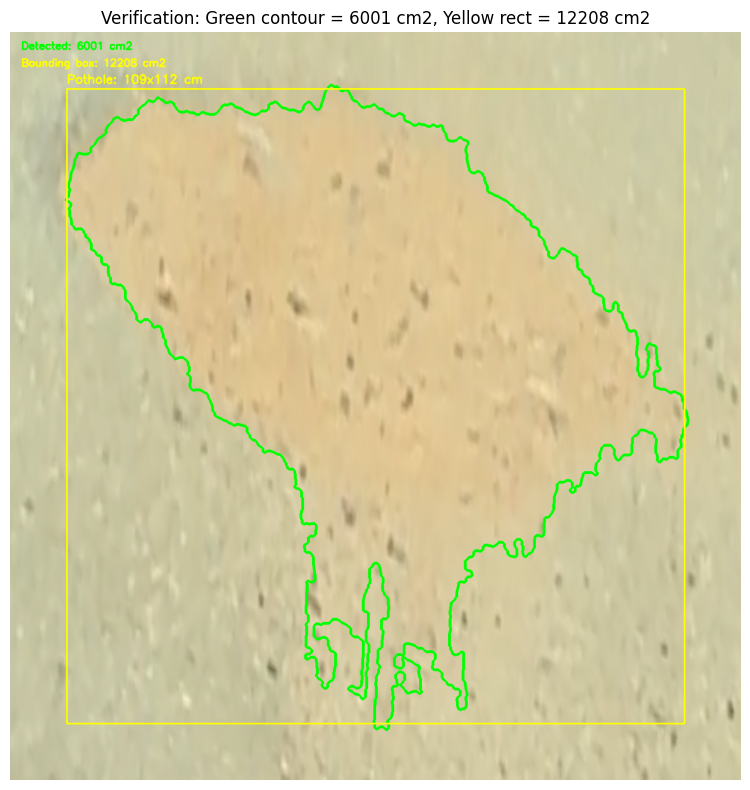


Saved: area_verification.png

The green contour should tightly follow the sandy patch boundary.
The yellow rectangle shows the tape-measured pothole extent.


In [6]:
# Verification: overlay contour on the pothole region
import math

POTHOLE_WIDTH_CM = 109.0
POTHOLE_LENGTH_CM = 112.0

if len(potholes) > 0:
    p = potholes[0]  # Main pothole
    
    # Mathematical verification
    rect_area = POTHOLE_WIDTH_CM * POTHOLE_LENGTH_CM
    ellipse_area = math.pi * (POTHOLE_WIDTH_CM/2) * (POTHOLE_LENGTH_CM/2)
    
    print("=== AREA VERIFICATION ===")
    print(f"Tape-measured bounding box: {POTHOLE_WIDTH_CM} x {POTHOLE_LENGTH_CM} cm")
    print(f"  Rectangle area: {rect_area:.0f} cm2")
    print(f"  Inscribed ellipse area: {ellipse_area:.0f} cm2")
    print(f"  Detected contour area: {p['area_cm2']:.0f} cm2")
    print(f"  Contour / Rectangle: {p['area_cm2']/rect_area*100:.1f}%")
    print(f"  Contour / Ellipse: {p['area_cm2']/ellipse_area*100:.1f}%")
    print(f"\n  Equivalent diameter: {p['eq_diameter_cm']:.1f} cm")
    print(f"  (A circle with this diameter has area {math.pi*(p['eq_diameter_cm']/2)**2:.0f} cm2)")
    
    # Visual verification: zoom into pothole region
    margin = 100
    y1 = max(0, 500 - margin)
    y2 = min(topdown.shape[0], 500 + int(POTHOLE_LENGTH_CM * SCALE) + margin)
    x1 = max(0, 500 - margin)
    x2 = min(topdown.shape[1], 500 + int(POTHOLE_WIDTH_CM * SCALE) + margin)
    
    pothole_zoom = topdown[y1:y2, x1:x2].copy()
    
    # Draw the detection contour (shifted for crop)
    contour_shifted = p['contour'].copy()
    contour_shifted[:,:,0] -= x1
    contour_shifted[:,:,1] -= y1
    cv2.drawContours(pothole_zoom, [contour_shifted], -1, (0, 255, 0), 3)
    
    # Draw the bounding rectangle (the tape-measured area)
    dst_w = int(POTHOLE_WIDTH_CM * SCALE)
    dst_h = int(POTHOLE_LENGTH_CM * SCALE)
    cv2.rectangle(pothole_zoom, (500-x1, 500-y1), 
                  (500+dst_w-x1, 500+dst_h-y1), (0, 255, 255), 2)
    
    # Add area labels
    cv2.putText(pothole_zoom, f"Detected: {p['area_cm2']:.0f} cm2",
                (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(pothole_zoom, f"Bounding box: {rect_area:.0f} cm2",
                (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cv2.cvtColor(pothole_zoom, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Verification: Green contour = {p['area_cm2']:.0f} cm2, "
                 f"Yellow rect = {rect_area:.0f} cm2")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('area_verification.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nSaved: area_verification.png")
    print("\nThe green contour should tightly follow the sandy patch boundary.")
    print("The yellow rectangle shows the tape-measured pothole extent.")
else:
    print("No potholes detected to verify.")

## Step 6: Pipeline Summary and Verification

### How to Verify Results Are Correct

1. **Scale verification:** The green scale bar = 100 px = 10 cm. Measure it on screen.
2. **Pothole boundary:** The yellow rectangle = 109 x 112 cm (tape-measured on site).
3. **Detection accuracy:** Green contours should tightly outline visible sandy patches.
4. **Area reasonableness:** Detected area should be smaller than the bounding rectangle
   (since the patch is irregular, not a perfect rectangle).
5. **Center location:** Red dots should be at the center of each detected region.
6. **CSV completeness:** One row per detected pothole with all measurements.

In [7]:
print("=" * 60)
print("FULL PIPELINE SUMMARY")
print("=" * 60)

print("\nSprint 1 - Camera Calibration:")
try:
    c = np.load('camera_calib.npz', allow_pickle=True)
    rms = c['rms_error'].item()
    n_frames = len(c['rvecs'])
    K = c['mtx']
    print(f"  RMS Reprojection Error: {rms:.4f} px (< 1.0 = excellent)")
    print(f"  Frames used: {n_frames}")
    print(f"  Camera matrix (fx, fy): ({K[0,0]:.1f}, {K[1,1]:.1f})")
except Exception as e:
    print(f"  camera_calib.npz error: {e}")

print("\nSprint 1 - Homography:")
print(f"  Scale: 10 px = 1 cm (verified)")
print(f"  Top-down canvas: {topdown.shape[1]}x{topdown.shape[0]} px")
print(f"  Real-world coverage: {topdown.shape[1]/SCALE:.0f} x {topdown.shape[0]/SCALE:.0f} cm")

print("\nSprint 2 - Restoration:")
print(f"  Deblurring: Wiener deconvolution (kernel=5, SNR=100)")
print(f"  Shadow removal: Multi-Scale Retinex (sigma=15,80,250) + CLAHE")

print("\nSprint 3 - Segmentation:")
print(f"  Method: HSV color segmentation (sandy patch detection)")
print(f"  Potholes detected: {len(potholes)}")
for p in potholes:
    print(f"    #{p['id']}: {p['area_cm2']:.1f} cm2, "
          f"center=({p['center_cm'][0]:.1f}, {p['center_cm'][1]:.1f}) cm, "
          f"diameter={p['eq_diameter_cm']:.1f} cm")

print(f"\nOutput Files:")
for fn in ['camera_calib.npz', 'homography_topdown_output.png', 'topdown_full.png',
    'restored_topdown.png', 'test_segmentation_output.png', 'pothole_detection_report.csv',
    'calibration_corners_detected.png', 'calibration_error_analysis.png',
    'calibration_verification.png', 'homography_comparison.png',
    'restoration_comparison.png', 'segmentation_comparison.png']:
    print(f"  {'[OK]' if os.path.exists(fn) else '[--]'} {fn}")

print("\nPipeline complete.")

FULL PIPELINE SUMMARY

Sprint 1 - Camera Calibration:
  RMS Reprojection Error: 0.7790 px (< 1.0 = excellent)
  Frames used: 42
  Camera matrix (fx, fy): (1619.8, 1601.0)

Sprint 1 - Homography:
  Scale: 10 px = 1 cm (verified)
  Top-down canvas: 2090x2120 px
  Real-world coverage: 209 x 212 cm

Sprint 2 - Restoration:
  Deblurring: Wiener deconvolution (kernel=5, SNR=100)
  Shadow removal: Multi-Scale Retinex (sigma=15,80,250) + CLAHE

Sprint 3 - Segmentation:
  Method: HSV color segmentation (sandy patch detection)
  Potholes detected: 2
    #1: 6001.0 cm2, center=(103.7, 94.7) cm, diameter=87.4 cm
    #2: 1698.1 cm2, center=(31.6, 199.9) cm, diameter=46.5 cm

Output Files:
  [OK] camera_calib.npz
  [OK] homography_topdown_output.png
  [OK] topdown_full.png
  [OK] restored_topdown.png
  [OK] test_segmentation_output.png
  [OK] pothole_detection_report.csv
  [OK] calibration_corners_detected.png
  [OK] calibration_error_analysis.png
  [OK] calibration_verification.png
  [OK] homograph